In [1]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display
import geemap as gee
import xarray as xr
!pip install xee
import xee
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize( project = 'ee-mussamahammed1', opt_url = 'https://earthengine-highvolume.googleapis.com')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00


In [3]:
# ---------------------------
# 1. Load Dataset and Define Parameters
# ---------------------------
gaul1 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1")
countries = ['Ethiopia', 'Kenya', 'Somalia', 'Sudan']

drought_classes = {
    'VCI': {'Extreme': [0, 10], 'Severe': [10, 20], 'Moderate': [20, 30], 'Mild': [30, 40], 'Normal': [40, 100]},
    'TCI': {'Extreme': [0, 10], 'Severe': [10, 20], 'Moderate': [20, 30], 'Mild': [30, 40], 'Normal': [40, 100]},
    'VHI': {'Extreme': [0, 15], 'Severe': [15, 25], 'Moderate': [25, 35], 'Mild': [35, 45], 'Normal': [45, 100]}
}

# ---------------------------
# 2. Define UI Components
# ---------------------------
country_dropdown = widgets.Dropdown(options=countries, description='Country:', style={'description_width': '120px'})
region_select = widgets.SelectMultiple(description='Regions:', style={'description_width': '120px'}, rows=8)
variable_select = widgets.Dropdown(options=['VCI', 'TCI', 'VHI'], description='Index:', style={'description_width': '120px'})
start_year = widgets.IntText(value=2002, description='Start Year:')
end_year = widgets.IntText(value=2024, description='End Year:')
start_month = widgets.Dropdown(options=[(f'{i:02d}', i) for i in range(1, 13)], value=1, description='Start Month:')
end_month = widgets.Dropdown(options=[(f'{i:02d}', i) for i in range(1, 13)], value=12, description='End Month:')
run_button = widgets.Button(description="Analyze", button_style='success', layout=widgets.Layout(width='120px'))
help_button = widgets.Button(description="Help", button_style='info', layout=widgets.Layout(width='120px'))
reset_button = widgets.Button(description="Reset", button_style='warning', layout=widgets.Layout(width='120px'))
output = widgets.Output()
map_output = widgets.Output()

region_dict = {
    'Ethiopia': ['Addis Ababa', 'Afar', 'Amhara', 'Benshangul-Gumuz', 'Gambela', 'Harari', 'Oromia', 'Southern Nations, Nationalities and Peoples', 'Tigray', 'Dire Dawa', 'Somali'],
    'Kenya': ['Central', 'Coast', 'Eastern', 'Nairobi', 'North Eastern', 'Nyanza', 'Rift Valley', 'Western'],
    'Somalia': ['Awdal', 'Bakool', 'Bari', 'Bay', 'Banadir', 'Galgaduud', 'Gedo', 'Hiraan', 'Juba Dhexe', 'Juba Hoose', 'Shabelle Dhexe', 'Shabelle Hoose', 'Mudug', 'Nugaal', 'Sanaag', 'Sool', 'Togdheer', 'Woqooyi Galbeed'],
    'Sudan': ['Al Jazeera', 'Blue Nile', 'Gadaref', 'Kassala', 'Khartoum', 'Nile', 'Northern', 'Northern Darfur', 'Northern Kordofan', 'Red Sea', 'Sennar', 'Southern Darfur', 'Southern Kordofan', 'Western Darfur', 'White Nile']
}

def update_regions(change):
    if change['new'] in region_dict:
        region_select.options = region_dict[change['new']]
        region_select.value = ()

def reset_app(b):
    country_dropdown.value = None
    region_select.options = []
    region_select.value = ()
    variable_select.value = None
    start_year.value = 2002
    end_year.value = 2024
    start_month.value = 1
    end_month.value = 12
    with output:
        output.clear_output()
    with map_output:
        map_output.clear_output()
    print("🔄 App has been reset to default values")

def classify_drought(image, variable):
    classes = drought_classes[variable]
    classified = (image.gte(classes['Extreme'][0]).And(image.lt(classes['Extreme'][1])).multiply(1)
        .add(image.gte(classes['Severe'][0]).And(image.lt(classes['Severe'][1])).multiply(2))
        .add(image.gte(classes['Moderate'][0]).And(image.lt(classes['Moderate'][1])).multiply(3))
        .add(image.gte(classes['Mild'][0]).And(image.lt(classes['Mild'][1])).multiply(4))
        .add(image.gte(classes['Normal'][0]).And(image.lte(classes['Normal'][1])).multiply(5))
        .rename('drought_class'))
    return classified.copyProperties(image, ['system:time_start'])

def run_analysis(b):
    output.clear_output()
    print("⏳ Processing...")
    country = country_dropdown.value
    regions = region_select.value
    variable = variable_select.value
    sy, ey = start_year.value, end_year.value
    sm, em = start_month.value, end_month.value

    if not country or not regions or not variable:
        print("❌ Please select country, regions, and drought index")
        return

    region_features = gaul1.filter(ee.Filter.eq('ADM0_NAME', country)).filter(ee.Filter.inList('ADM1_NAME', list(regions)))
    if region_features.size().getInfo() == 0:
        print("❌ No matching regions found")
        return

    region_geom = region_features.union()
    start_date = ee.Date.fromYMD(sy, sm, 1)
    end_date = ee.Date.fromYMD(ey, em, 1).advance(1, 'month').advance(-1, 'day')

    ndvi_coll = ee.ImageCollection("MODIS/061/MOD13A2").select('NDVI').filterDate(start_date, end_date)
    lst_coll = ee.ImageCollection("MODIS/061/MOD11A2").select('LST_Day_1km').filterDate(start_date, end_date)

    if ndvi_coll.size().getInfo() == 0 or lst_coll.size().getInfo() == 0:
        with output:
            print("❌ No data available for selected period for NDVI or LST.")
        return

    ndvi_scaled = ndvi_coll.map(lambda img: img.multiply(0.0001).copyProperties(img, ['system:time_start']))
    lst_scaled = lst_coll.map(lambda img: img.multiply(0.02).copyProperties(img, ['system:time_start']))

    if variable == 'VCI':
        min_val = ndvi_scaled.min()
        max_val = ndvi_scaled.max()
        index = ndvi_scaled.map(lambda img: img.subtract(min_val).divide(max_val.subtract(min_val)).multiply(100).rename('VCI').copyProperties(img, ['system:time_start']))
    elif variable == 'TCI':
        min_val = lst_scaled.min()
        max_val = lst_scaled.max()
        index = lst_scaled.map(lambda img: max_val.subtract(img).divide(max_val.subtract(min_val)).multiply(100).rename('TCI').copyProperties(img, ['system:time_start']))
    else:
        ndvi_min = ndvi_scaled.min()
        ndvi_max = ndvi_scaled.max()
        lst_min = lst_scaled.min()
        lst_max = lst_scaled.max()

        vci_coll = ndvi_scaled.map(lambda img: img.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).multiply(100).rename('VCI').copyProperties(img, ['system:time_start']))
        tci_coll = lst_scaled.map(lambda img: lst_max.subtract(img).divide(lst_max.subtract(lst_min)).multiply(100).rename('TCI').copyProperties(img, ['system:time_start']))

        filter_timeEq = ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
        join = ee.Join.inner()
        joined = join.apply(vci_coll, tci_coll, filter_timeEq)

        def compute_vhi(el):
            primary = ee.Image(el.get('primary'))
            secondary = ee.Image(el.get('secondary'))
            vhi = primary.select('VCI').multiply(0.5).add(secondary.select('TCI').multiply(0.5)).rename('VHI')
            return vhi.copyProperties(primary, ['system:time_start'])

        index = ee.ImageCollection(joined.map(compute_vhi))

    classified = index.map(lambda img: classify_drought(img, variable))
    mean_class = classified.mean().clip(region_geom)

    vis_params = {'min': 1, 'max': 5, 'palette': ['d73027', 'fc8d59', 'fee08b', 'd9ef8b', '91cf60'], 'bands': 'drought_class'}
    legend_dict = {'Extreme Drought': 'd73027', 'Severe Drought': 'fc8d59', 'Moderate Drought': 'fee08b', 'Mild Drought': 'd9ef8b', 'Normal Conditions': '91cf60'}

    with map_output:
        map_output.clear_output()
        Map = geemap.Map()
        Map.centerObject(region_geom, 6)
        Map.addLayer(region_features.style(**{'color': 'blue', 'fillColor': '00000000'}), {}, 'Selected Regions')
        Map.addLayer(mean_class, vis_params, f'{variable} Drought Classification')
        Map.add_legend(title=f'{variable} Drought Severity', legend_dict=legend_dict, position='topright')
        display(Map)

    # Export the mean classified image to your Google Drive
    task = ee.batch.Export.image.toDrive(
        image=mean_class.toUint8(),
        description=f"{variable}_Drought_{country}",
        folder='GEE_Exports',
        fileNamePrefix=f"{variable}_{country}_{sy}_{ey}",
        region=region_geom.geometry(),
        scale=1000,
        maxPixels=1e13
    )
    task.start()

    with output:
        print(f"✅ Analysis complete for {len(regions)} regions in {country}")
        print(f"📅 Period: {sm:02d}/{sy} to {em:02d}/{ey}")
        print("\n💡 Interpretation Guide:")
        print(f"VCI Values: 0-40 = Drought, 40-100 = Normal")
        print(f"TCI Values: 0-40 = Drought, 40-100 = Normal")
        print(f"VHI Values: 0-35 = Drought, 35-100 = Normal")
        print("📤 Export started: Check your Google Drive > GEE_Exports")

def show_help(b):
    output.clear_output()
    print("""
    🌍 Drought Monitoring App Help

    HOW TO USE:
    1. Select a country from the dropdown
    2. Choose one or more regions (hold Ctrl/Cmd to multi-select)
    3. Select drought index:
       - VCI: Vegetation Condition Index (plant stress)
       - TCI: Temperature Condition Index (heat stress)
       - VHI: Vegetation Health Index (combined)
    4. Set date range
    5. Click \"Analyze\"

    DROUGHT CLASSIFICATION:
    - Extreme: Most severe drought conditions
    - Severe: Significant drought impact
    - Moderate: Noticeable drought effects
    - Mild: Early signs of drought
    - Normal: Healthy vegetation conditions

    DATA SOURCES:
    - MODIS NDVI (MOD13A2) for vegetation
    - MODIS LST (MOD11A2) for temperature

    TIPS:
    - Compare multiple time periods
    - Use VHI for most comprehensive assessment
    - Check specific regions for local impacts
    """)

country_dropdown.observe(update_regions, names='value')
run_button.on_click(run_analysis)
help_button.on_click(show_help)
reset_button.on_click(reset_app)

ui = widgets.VBox([
    widgets.HTML("<h1 style='color:#1a5276; text-align:center'>🌾 Drought Severity Monitor</h1>"),
    widgets.HBox([
        widgets.VBox([
            widgets.HTML("<h3 style='color:#2874a6'>1. Select Area</h3>"),
            country_dropdown,
            region_select,
            widgets.HTML("<small>Hold Ctrl/Cmd to select multiple regions</small>")
        ]),
        widgets.VBox([
            widgets.HTML("<h3 style='color:#2874a6'>2. Select Parameters</h3>"),
            variable_select,
            widgets.HTML("<h3 style='color:#2874a6'>3. Set Date Range</h3>"),
            widgets.HBox([start_year, end_year]),
            widgets.HBox([start_month, end_month])
        ])
    ]),
    widgets.HBox([run_button, help_button, reset_button], layout=widgets.Layout(justify_content='center')),
    output,
    widgets.HTML("<h3 style='color:#2874a6'>🌍 Drought Classification Map</h3>"),
    map_output
])

display(ui)

In [ ]:
!pip install geopandas rasterio shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


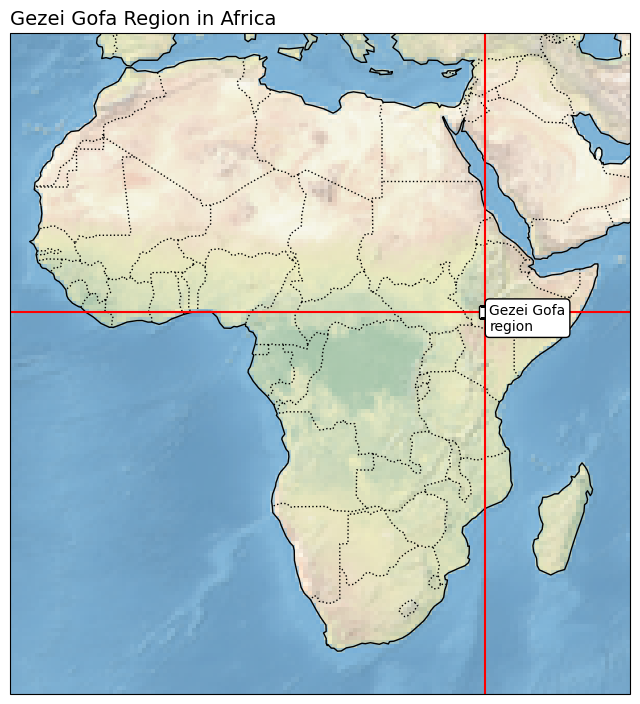

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axis with PlateCarree projection
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add natural features
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Gezei Gofa Region in Africa', fontsize=14, loc='left')

# Set the extent to cover Africa
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())

# Plot red cross lines
ax.plot([37.5, 37.5], [-40, 40], color='red', linewidth=1.5)  # vertical line
ax.plot([-20, 55], [6.2, 6.2], color='red', linewidth=1.5)    # horizontal line

# Mark the Gezei Gofa region
ax.plot(37.5, 6.2, marker='s', color='white', markersize=8, markeredgecolor='black', transform=ccrs.PlateCarree())
ax.text(38, 4, 'Gezei Gofa\nregion', fontsize=10, color='black', transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.show()


In [ ]:
!pip install matplotlib-scalebar


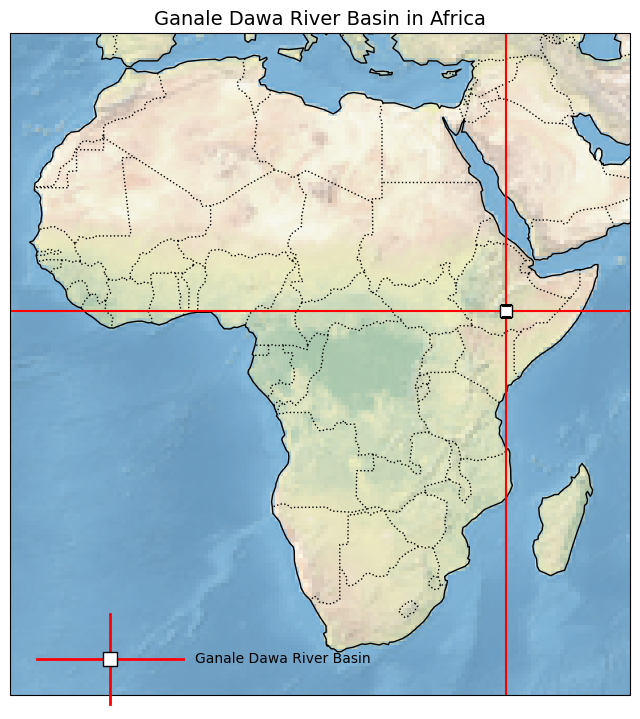

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Ganale Dawa River Basin in Africa', fontsize=14, loc='center')
# Set extent to Africa
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())

# Coordinates of Ganale Dawa River Basin
gofa_lon, gofa_lat = 40.02, 6.36

# Red cross lines
ax.plot([gofa_lon, gofa_lon], [-40, 40], color='red', linewidth=1.50)
ax.plot([-20, 55], [gofa_lat, gofa_lat], color='red', linewidth=1.50)

# White square marker at intersection
ax.plot(gofa_lon, gofa_lat, marker='s', color='white', markersize=8, markeredgecolor='black', transform=ccrs.PlateCarree())

# Inset legend box (as a manual legend using patches)
legend_ax = fig.add_axes([0.15, 0.15, 0.2, 0.1])  # [left, bottom, width, height]
legend_ax.axis('off')  # hide axis

# Draw red cross manually
legend_ax.plot([0.5, 0.5], [0.2, 0.8], color='red', linewidth=2)
legend_ax.plot([0.2, 0.8], [0.5, 0.5], color='red', linewidth=2)
legend_ax.plot(0.5, 0.5, marker='s', color='white', markersize=10, markeredgecolor='black')

# Add text
legend_ax.text(0.850, 0.5, 'Ganale Dawa River Basin', fontsize=10, va='center')

plt.show()


/tmp/ipython-input-15-2164219582.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


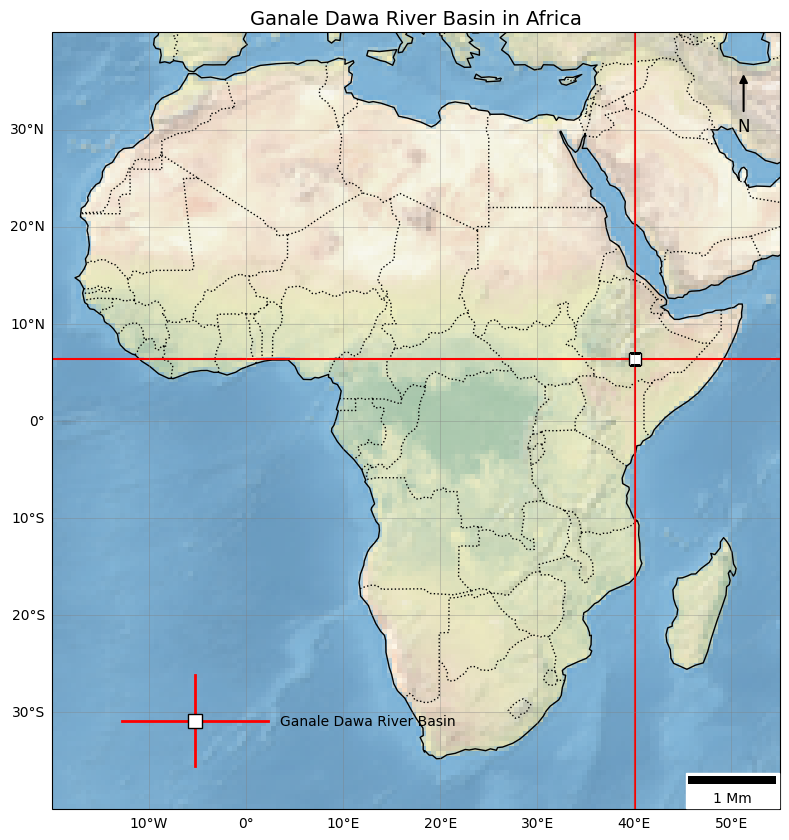

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Ganale Dawa River Basin in Africa', fontsize=14, loc='center')

# Set extent to Africa
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())

# Coordinates of Ganale Dawa River Basin
gofa_lon, gofa_lat = 40.02, 6.36

# Red cross lines
ax.plot([gofa_lon, gofa_lon], [-40, 40], color='red', linewidth=1.50)
ax.plot([-20, 55], [gofa_lat, gofa_lat], color='red', linewidth=1.50)

# White square marker at intersection
ax.plot(gofa_lon, gofa_lat, marker='s', color='white', markersize=8,
        markeredgecolor='black', transform=ccrs.PlateCarree())

# Inset legend box
legend_ax = fig.add_axes([0.15, 0.15, 0.2, 0.1])
legend_ax.axis('off')
legend_ax.plot([0.5, 0.5], [0.2, 0.8], color='red', linewidth=2)
legend_ax.plot([0.2, 0.8], [0.5, 0.5], color='red', linewidth=2)
legend_ax.plot(0.5, 0.5, marker='s', color='white', markersize=10,
               markeredgecolor='black')
legend_ax.text(0.850, 0.5, 'Ganale Dawa River Basin', fontsize=10, va='center')

# Add North Arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.88),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=1.5),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)

# Add Gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add Scale Bar
scalebar = ScaleBar(dx=111000, units='m', location='lower right', scale_loc='bottom')
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 99.8 MB/s eta 0:00:00


In [ ]:
import ee
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import mapping
import numpy as np

# Initialize GEE
ee.Initialize()

# Load shapefile
gdf = gpd.read_file("Ganale_Dawa_Basin.shp")
geom = mapping(gdf.unary_union)
roi = ee.Geometry.Polygon(geom['coordinates'])

# Load SRTM elevation data
elevation = ee.Image("USGS/SRTMGL1_003").clip(roi)

# Export elevation to numpy array
url = elevation.getDownloadURL({
    'scale': 90,
    'region': roi,
    'format': 'NPY'
})

# ---- Alternative: use geemap if installed
# import geemap
# array = geemap.ee_to_numpy(elevation.select('elevation'), region=roi, scale=90)

# Manually download and load array (or skip if using geemap)
import urllib.request
urllib.request.urlretrieve(url, 'elevation.npy')
elev_array = np.load('elevation.npy')

# Get extent
minx, miny, maxx, maxy = gdf.total_bounds
extent = [minx, maxx, miny, maxy]

# ---------------------
# Plotting
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot elevation
img = ax.imshow(np.squeeze(elev_array), extent=extent, origin='upper', cmap='terrain', transform=ccrs.PlateCarree())

# Add boundary
gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Title
ax.set_title('Ganale Dawa River Basin, Ethiopia', fontsize=14, loc='center')

# Add coordinates (ticks)
ax.set_xticks(np.linspace(minx, maxx, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(miny, maxy, 5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=10)

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7, pad=0.02, label='Elevation (m)')

# Add scale bar
scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right', scale_loc='bottom')
ax.add_artist(scalebar)

# Add north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.88),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=1.5),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)

plt.tight_layout()
plt.show()
